In [481]:
from datetime import date
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("../Resources/btcjoin.csv", parse_dates=['date'])
df = df.drop(columns=['volume','change', 'low', 'high', 'open'])
df = df.rename(columns={"value": "wallets"})
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
df.dtypes

#https://dcresearch.medium.com/metcalfes-law-and-bitcoin-s-value-2b99c7efd1fa

date       datetime64[ns]
price             float64
wallets             int64
address           float64
mined             float64
dtype: object

In [482]:
df['Metcafe']=df['address']**2
df['value'] = df['Metcafe']/df['mined']
df["value"] = df["value"].map("{:.2f}".format)
df['value']=df['value'].astype("float")
df['networkvalue'] = df["price"] - df["value"]
df.dtypes


date            datetime64[ns]
price                  float64
wallets                  int64
address                float64
mined                  float64
Metcafe                float64
value                  float64
networkvalue           float64
dtype: object

In [483]:
df

,date,price,wallets,address,mined,Metcafe,value,networkvalue
0,2010-09-25,0.1,2,656.0,4109450.00,4.303360e+05,0.10,0.00
1,2010-09-26,0.1,2,444.0,4110750.00,1.971360e+05,0.05,0.05
2,2010-09-27,0.1,2,1070.0,4132150.00,1.144900e+06,0.28,-0.18
3,2010-09-28,0.1,2,1503.0,4133200.00,2.259009e+06,0.55,-0.45
4,2010-09-29,0.1,2,1049.0,4148050.00,1.100401e+06,0.27,-0.17
...,...,...,...,...,...,...,...,...
4381,2022-10-21,19162.6,84879615,924681.0,19185681.25,8.550350e+11,44566.31,-25403.71
4382,2022-10-22,19204.8,84888147,830404.0,19186618.75,6.895708e+11,35940.19,-16735.39
4383,2022-10-23,19571.2,84893809,804140.0,19187600.00,6.466411e+11,33700.99,-14129.79
4384,2022-10-24,19331.5,84902680,919344.0,19188556.25,8.451934e+11,44046.74,-24715.24


In [484]:
df_train = df[['date', 'price']]
df_train = df_train.rename(columns = {"date":"ds", "price":"y"})

m = Prophet()
m.fit(df_train)

n_years =2
period = n_years * 365
future = m.make_future_dataframe(periods = period)
forecast = m.predict(future)

15:11:24 - cmdstanpy - INFO - Chain [1] start processing
15:11:25 - cmdstanpy - INFO - Chain [1] done processing


In [485]:
forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5111,2024-10-20,67579.622795,57710.560941,77825.642301
5112,2024-10-21,67786.517389,57751.892895,77058.546940
5113,2024-10-22,67956.169026,58702.042842,77956.496129
5114,2024-10-23,68193.892712,58713.776887,78243.520279
5115,2024-10-24,68339.782496,58759.713459,77599.149320


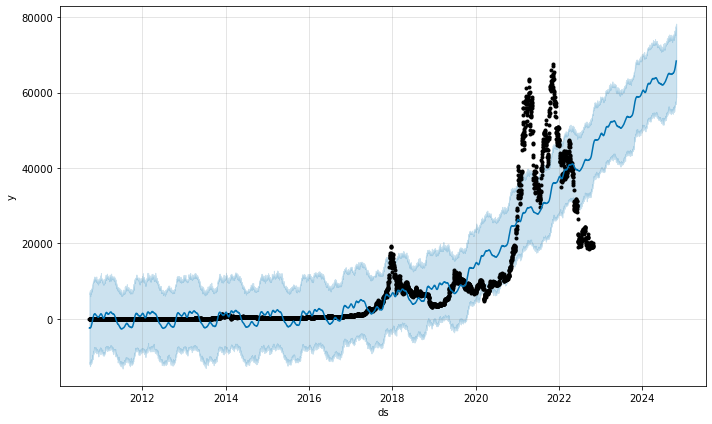

In [486]:
fig1 = m.plot(forecast)
plt.savefig("../static/autocorrelationprices.png", dpi = 72)

In [487]:
df_train = df[['date', 'price']]
df_train = df_train.rename(columns = {"date":"ds", "price":"y"})

m = Prophet()
m.fit(df_train)

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

15:11:27 - cmdstanpy - INFO - Chain [1] start processing
15:11:27 - cmdstanpy - INFO - Chain [1] done processing
15:11:27 - cmdstanpy - INFO - Chain [1] start processing
15:11:28 - cmdstanpy - INFO - Chain [1] done processing


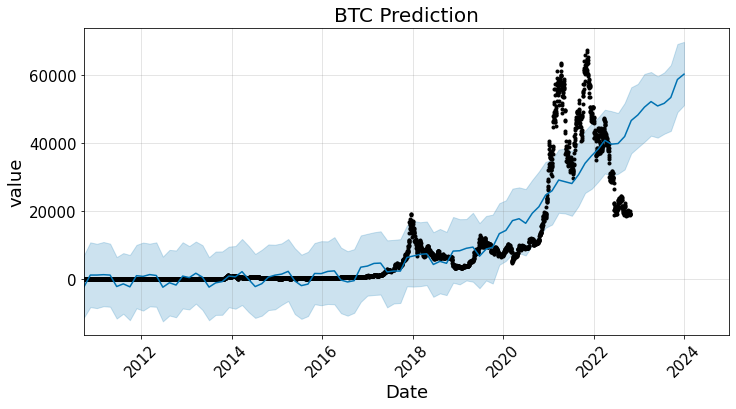

In [488]:
# Create a data frame that lists dates from Oct - Dec 2017
insample = pd.DataFrame(pd.date_range("2010-09-25", "2024-01-01", periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("BTC Prediction", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("value", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2010-09-25', '2024-12-31'])) 
plt.show();

In [489]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(name="Actual", x=df_train['ds'], y=df_train['y'], legendrank=4))
fig.add_trace(go.Scatter(name="Upper Bound Prediction", x=prediction['ds'], y=prediction['yhat'], legendrank=2))
fig.add_trace(go.Scatter(name="Lower Bound Prediction", x=prediction['ds'], y=prediction['yhat_lower'], legendrank=1))

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)
fig.update_layout(title_text='Bitcoin Prices and Date Prediction')
fig.update_yaxes(ticklabelposition="inside top", title="Bitcoin Prices")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=20)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.show()
fig.write_html('../static/prices.html')

In [490]:
import plotly.express as px
from numpy import log

fig = px.line(x=df['date'], y=(df['networkvalue']))


fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)


fig.show()

In [491]:
df['status'] = df['networkvalue'].apply(lambda x: '1' if x > 0 else '0')
# Create our features
X = df.drop(columns="status")
X = pd.get_dummies(X)

# Create our target
X = df.drop(columns="date")
y = df['status']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, train_size=0.70)


In [492]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

In [493]:
## Logistic Regression
from sklearn.linear_model import LogisticRegression
LRclf = LogisticRegression().fit(X_train, y_train)
y_pred = LRclf.predict(X_test)
print(f'Training Score: {LRclf.score(X_train, y_train)}')
print(f'Testing Score: {LRclf.score(X_test, y_test)}')
print(classification_report(y_test, y_pred))
balanced_accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
cm_df


Training Score: 0.9397394136807817
Testing Score: 0.9369300911854104
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1233
           1       0.00      0.00      0.00        83

    accuracy                           0.94      1316
   macro avg       0.47      0.50      0.48      1316
weighted avg       0.88      0.94      0.91      1316



c:\Users\16474\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\16474\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\16474\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Predicted 0,Predicted 1
Actual 0,1233,0
Actual 1,83,0


In [495]:
from sklearn.tree import DecisionTreeClassifier
## DecisionTreeClassifier
DTCclf = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = DTCclf.predict(X_test)
print(f'Training Score: {DTCclf.score(X_train, y_train)}')
print(f'Testing Score: {DTCclf.score(X_test, y_test)}')
print(classification_report(y_test, y_pred)) 
print(balanced_accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
cm_df



Training Score: 1.0
Testing Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1233
           1       1.00      1.00      1.00        83

    accuracy                           1.00      1316
   macro avg       1.00      1.00      1.00      1316
weighted avg       1.00      1.00      1.00      1316

1.0


,Predicted 0,Predicted 1
Actual 0,1233,0
Actual 1,0,83


In [496]:
## RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
RFCclf = RandomForestClassifier(random_state=1, n_estimators=3000).fit(X_train, y_train)
y_pred = RFCclf.predict(X_test)
print(f'Training Score: {RFCclf.score(X_train, y_train)}')
print(f'Testing Score: {RFCclf.score(X_test, y_test)}')
print(classification_report(y_test, y_pred)) 
print(balanced_accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
cm_df




Training Score: 1.0
Testing Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1233
           1       1.00      1.00      1.00        83

    accuracy                           1.00      1316
   macro avg       1.00      1.00      1.00      1316
weighted avg       1.00      1.00      1.00      1316

1.0


,Predicted 0,Predicted 1
Actual 0,1233,0
Actual 1,0,83


In [497]:
## ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
ETCclf = ExtraTreesClassifier(random_state=1, n_estimators=3000).fit(X_train, y_train)
y_pred = ETCclf.predict(X_test)
print(f'Training Score: {ETCclf.score(X_train, y_train)}')
print(f'Testing Score: {ETCclf.score(X_test, y_test)}')
print(classification_report(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
cm_df



Training Score: 1.0
Testing Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1233
           1       1.00      1.00      1.00        83

    accuracy                           1.00      1316
   macro avg       1.00      1.00      1.00      1316
weighted avg       1.00      1.00      1.00      1316

1.0


,Predicted 0,Predicted 1
Actual 0,1233,0
Actual 1,0,83


In [498]:
## AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
ADAclf = AdaBoostClassifier(random_state=1, n_estimators=3000, base_estimator=DecisionTreeClassifier(max_depth=2)).fit(X_train, y_train)
y_pred = ADAclf.predict(X_test)
print(f'Training Score: {ADAclf.score(X_train, y_train)}')
print(f'Testing Score: {ADAclf.score(X_test, y_test)}')
print(classification_report(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
cm_df


Training Score: 1.0
Testing Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1233
           1       1.00      1.00      1.00        83

    accuracy                           1.00      1316
   macro avg       1.00      1.00      1.00      1316
weighted avg       1.00      1.00      1.00      1316

1.0


,Predicted 0,Predicted 1
Actual 0,1233,0
Actual 1,0,83
